Shape after filtering: (400, 400, 189)


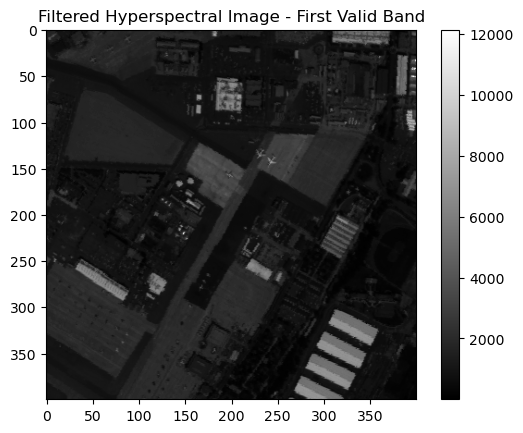

In [18]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
mat = scipy.io.loadmat(r"D:\Hackathons\SIH\Hyperspectral-Anomaly-Detection\Sandiego.mat")
hyperspectral_data = mat['Sandiego']
height, width, bands = hyperspectral_data.shape

valid_bands = list(set(range(bands)) - set(range(0, 6)) - set(range(32, 35)) - set([96]) 
                   - set(range(106, 113)) - set(range(152, 166)) - set(range(220, 224)))

filtered_data = hyperspectral_data[:, :, valid_bands]

print(f"Shape after filtering: {filtered_data.shape}")

band = filtered_data[:, :, 0]

plt.imshow(band, cmap='gray')
plt.colorbar()
plt.title('Filtered Hyperspectral Image - First Valid Band')
plt.show()


In [2]:
hyperspectral_data

array([[[ -284,   844,  1196, ...,  1766,  1639,     0],
        [ -284,   844,  1196, ...,  1523,  2059,     0],
        [-1018,   844,  1196, ...,  1766,  1807,     0],
        ...,
        [ 2010,  3287,  3620, ...,  4899,  5130,     0],
        [ 2737,  3287,  3620, ...,  4899,  5464,     0],
        [  455,  2060,  2223, ...,  2360,  2878,     0]],

       [[ -284,   844,  1196, ...,  1766,  1639,     0],
        [ -341,  1237,  1191, ...,  2009,  1639,     0],
        [-1018,   844,  1196, ...,  1766,  1807,     0],
        ...,
        [  455,  1662,  2022, ...,  1755,  2044,     0],
        [  455,  1662,  2022, ...,  2239,  2712,     0],
        [  455,  2060,  2223, ...,  2360,  2878,     0]],

       [[ -341,  1237,  1394, ...,  1279,  2395,     0],
        [ -341,  1237,  1191, ...,  2009,  1639,     0],
        [ -341,   839,  1191, ...,  1279,  1723,     0],
        ...,
        [ -322,  1274,  1622, ...,  2239,  2044,     0],
        [  455,  1662,  2022, ...,  2239,  27

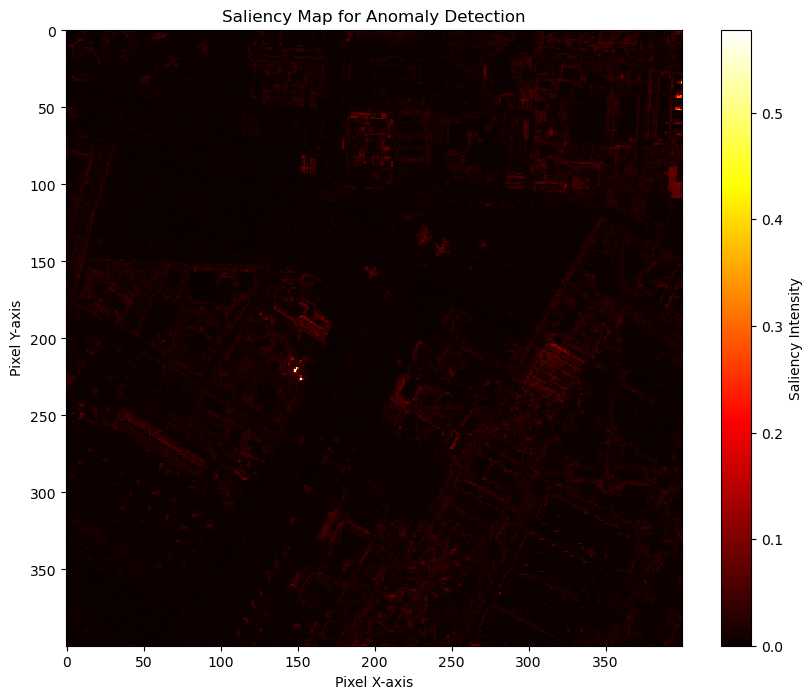

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import closing, opening, square
from skimage import exposure

# Assume `hyperspectral_data` is our input hyperspectral image data with shape (height, width, bands)

# Step 1: Apply Morphological Operations for Saliency Map Generation
# Define structuring element size for morphological operations
structuring_element_size = 3
selem = square(structuring_element_size)

# Apply closing and opening to each band in the hyperspectral data
closed_hsi = np.zeros_like(hyperspectral_data)
opened_hsi = np.zeros_like(hyperspectral_data)

for i in range(hyperspectral_data.shape[2]):
    closed_hsi[:, :, i] = closing(hyperspectral_data[:, :, i], selem)
    opened_hsi[:, :, i] = opening(hyperspectral_data[:, :, i], selem)

# Step 2: Calculate Differential Map X
# Differential map highlights both dark and bright small regions
saliency_map = np.abs(hyperspectral_data - opened_hsi) + np.abs(hyperspectral_data - closed_hsi)

# Normalize the saliency map for consistent scaling
saliency_map_normalized = exposure.rescale_intensity(saliency_map, out_range=(0, 1))

# Visualize the Saliency Map
plt.figure(figsize=(10, 8))
mean_saliency_map = np.mean(saliency_map_normalized, axis=2)  # Average across spectral bands
plt.imshow(mean_saliency_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Saliency Intensity')
plt.title('Saliency Map for Anomaly Detection')
plt.xlabel('Pixel X-axis')
plt.ylabel('Pixel Y-axis')
plt.show()

# Step 3: Define Pseudo-Background and Anomalous Vectors Using Coarse Search
# Threshold saliency map to separate background and anomalous regions
background_threshold = 0.2  # Threshold value; adjust as needed based on data characteristics
background_mask = saliency_map_normalized < background_threshold
anomaly_mask = saliency_map_normalized >= background_threshold

# Initialize lists for training and testing datasets
D_trn = []
D_tst = []

# Assign labels based on masks
for i in range(hyperspectral_data.shape[0]):
    for j in range(hyperspectral_data.shape[1]):
        spectral_vector = hyperspectral_data[i, j, :]
        normalized_vector = (spectral_vector - spectral_vector.min()) / (spectral_vector.max() - spectral_vector.min())
        
        if background_mask[i, j]:
            # Background vector with label 0
            D_trn.append((normalized_vector, 0))
        else:
            # Anomalous vector with label 1
            D_tst.append((normalized_vector, 1))

# Convert to arrays for training and testing datasets
D_trn = np.array(D_trn, dtype=object)  # Use dtype=object to handle variable lengths
D_tst = np.array(D_tst, dtype=object)  # Use dtype=object to handle variable lengths

# Now `D_trn` contains labeled background vectors, and `D_tst` contains both background and anomaly vectors
# Training data is `D_trn[:, 0]` (features) and `D_trn[:, 1]` (labels)
# Testing data is `D_tst[:, 0]` (features) and `D_tst[:, 1]` (labels)
